In [1051]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch import optim

# Load train and test datasets
In this section we load train and test datasets

In [1052]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [1053]:
from sklearn.utils import shuffle

In [1054]:
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [1055]:
df_train['CabinId'] = df_train['Cabin'].str[0]
df_test['CabinId'] = df_test['Cabin'].str[0]

In [1056]:
# PassengerId      - running counter. Not useful(Ignore)
# Survived         - Dependent variable
# Pclass           - 3 class feature
# Name             - Complex feature
# Sex              - No unknowns
# Age              - float feature with unknowns
# SibSp            - float feature in [0, 10]
# Parch            - float feature in [0, 10]
# Ticket           - 
# Fare             - ticket value from [0, 500]
# Cabin            - 687 unknowns, not very useful
# Embarked         - 3 class variable

In [1057]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [1058]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
CabinId        687
dtype: int64

# Feature engineering
We preprocess some features and extract more features. These include cabinIdx, Title and so on.
We also replace age with median age for the title

In [1059]:
df_train['Title'] = df_train['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
titles = df_train['Title'].unique()
titles

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [1060]:
df_test['Title'] = df_test['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
titles_test = df_test['Title'].unique()
titles_test

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [1061]:
df_train['Age'].fillna(-1, inplace=True)
df_test['Age'].fillna(-1, inplace=True)

median_age_for_title = dict()
counts_for_title = dict()
for title in titles:
    median = df_train.Age[(df_train["Age"] != -1) & (df_train['Title'] == title)].median()
    median_age_for_title[title] = median
    counts_for_title[title] = df_train.Title[df_train['Title'] == title].count()

In [1062]:
median_age_for_title_filtered = {k:v for (k, v) in median_age_for_title.items() if counts_for_title[k]>=3}
median_age_for_title_filtered

{'Dr': 46.5, 'Master': 3.5, 'Miss': 21.0, 'Mr': 30.0, 'Mrs': 35.0, 'Rev': 46.5}

In [1063]:
for index, row in df_train.iterrows():
    if row['Age'] == -1:
        if median_age_for_title_filtered.has_key(row['Title']):
            df_train.loc[index, 'Age'] = median_age_for_title_filtered[row['Title']]
        else:
            df_train.loc[index, 'Age'] = 28

In [1064]:
for index, row in df_test.iterrows():
    if row['Age'] == -1:
        if median_age_for_title_filtered.has_key(row['Title']):
            df_test.loc[index, 'Age'] = median_age_for_title_filtered[row['Title']]
        else:
            df_test.loc[index, 'Age'] = 28

# Dicts for categorical features
For features which are categorical, we use one hot encoding
and we look at the feature dicts.

In [1065]:
median_age_for_title_filtered.keys()

['Miss', 'Rev', 'Mrs', 'Master', 'Mr', 'Dr']

In [1066]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [1067]:
df_train['Sex'].unique()

array(['male', 'female'], dtype=object)

In [1068]:
df_train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [1081]:
df_train['CabinId'].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: CabinId, dtype: int64

In [1080]:
df_test['CabinId'].value_counts()

C    35
B    18
D    13
E     9
F     8
A     7
G     1
Name: CabinId, dtype: int64

In [1282]:
df_train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

# Define helper functions
This is not the best way. However its good enough to understand feature engineering.

In [1292]:
def one_hot_from_numeric(feature, max_dim, unknown_value_dim=0):
    feature_vec = torch.zeros(max_dim + 2)
    if feature is not None and not np.isnan(feature):
        feature_vec[int(feature)+1] = 1
    else:
        feature_vec[unknown_value_dim] = 1
    return feature_vec

In [1293]:
def one_hot_from_cat(feature, val_list= ['S', 'C', 'Q']):
    max_dim = len(val_list)
    feature_vec = torch.zeros(max_dim + 1)
    if feature is None:
        feature_vec[0] = 1
    else:
        for i in range(len(val_list)):
            if feature == val_list[i]:
                feature_vec[i+1] = 1
    return feature_vec

In [1294]:
def real_feature(val, default_val=None):
    feature_vec = torch.zeros(1)
    if val is not None and not np.isnan(val):
        feature_vec[0] = val
    elif default_val is not None:
        feature_vec[0] = default_val
    return feature_vec

In [1295]:
one_hot_from_cat(df_train.iloc[1]['Embarked'], ['S', 'C', 'Q'])

tensor([0., 0., 1., 0.])

In [1296]:
one_hot_from_numeric(50, 80)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [1297]:
one_hot_from_cat(df_train.iloc[1]['Title'], median_age_for_title_filtered.keys())

tensor([0., 0., 0., 1., 0., 0., 0.])

In [1298]:
one_hot_from_cat(df_train.iloc[1]['CabinId'], ['A', 'B', 'C', 'D', 'E', 'F', 'G'])

tensor([0., 0., 0., 1., 0., 0., 0., 0.])

In [1299]:
df_train.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked',
       u'CabinId', u'Title'],
      dtype='object')

# Implement feture parser and dataloader
In this section we define the feature parsing logic and also
write the logic for dataset creation. We can reuse these parametrized
functions for ablation studies or hyperparam tuning

In [1300]:
def get_featurized_data(row, extractLabel=True,
                        featureList = {'Embarked', 'Sex', 'Age', 'Age_1hot', 'SibSp', 'Parch', 'CabinId', 'Title', 
                                       'Fare', 'Pclass', 'Pclass_1hot'}):
    features = []
    if 'Embarked' in featureList:
        features.append(one_hot_from_cat(row['Embarked'], ['S', 'C', 'Q']))
    if 'Sex' in featureList:
        features.append(one_hot_from_cat(row['Sex'], ['male', 'female']))
    if 'Age' in featureList:
        features.append(real_feature(row['Age']))
    if 'Age_1hot' in featureList:
        features.append(one_hot_from_numeric(row['Age'], 81))
    if 'Pclass' in featureList:
        features.append(real_feature(row['Pclass']))
    if 'Pclass_1hot' in featureList:
        features.append(one_hot_from_numeric(row['Pclass'], 3))
    if 'SibSp' in featureList:
        features.append(real_feature(row['SibSp']))
    if 'Parch' in featureList:
        features.append(real_feature(row['Parch']))
    if 'Title' in featureList:
        features.append(one_hot_from_cat(row['Title'], median_age_for_title_filtered.keys()))
    if 'CabinId' in featureList:
        features.append(one_hot_from_cat(row['CabinId'], ['A', 'B', 'C', 'D', 'E', 'F', 'G']))
    if 'Fare' in featureList:
        features.append(real_feature(row['Fare']))
    Y = None
    if extractLabel:
        Y = real_feature(int(row['Survived']))
    X = torch.cat(features)
    return row['PassengerId'], X, Y

In [1301]:
def get_train_and_validation_set(df_train, bs=128, train_frac=0.9, featureList = {'Embarked', 'Sex', 'Age_1hot', 'Pclass_1hot', 'SibSp', 'Parch', 'CabinId', 'Title', 'Fare'}):
    df_train = shuffle(df_train)
    passenger_ids = []
    X_train = []
    Y_train = []
    for idx, row in df_train.iterrows():
        pid, X_row, Y_row = get_featurized_data(row, True, featureList)
        X_train.append(X_row)
        Y_train.append(Y_row)
        passenger_ids.append(pid)
        
    num_samples = len(X_train)
    num_features = X_train[0].shape[0]
    print ("Num_samples = {}, Num_features = {} from training csv".format(num_samples, num_features))

    split_point = int(train_frac*num_training_rows)
    tensor_x_train = torch.stack(X_train[:split_point]) # transform to torch tensors
    tensor_y_train = torch.stack(Y_train[:split_point])

    train_dataset = TensorDataset(tensor_x_train,tensor_y_train) # create your datset
    train_dataloader = DataLoader(train_dataset, batch_size=bs)
    #len(train_dataset)) # create your dataloader

    print ("split point is : {}".format(split_point))

    tensor_x_valid = torch.stack(X_train[split_point:]) # transform to torch tensors
    tensor_y_valid = torch.stack(Y_train[split_point:])

    validation_dataset = TensorDataset(tensor_x_valid,tensor_y_valid) # create your datset
    validation_dataloader = DataLoader(validation_dataset)
    return train_dataloader, validation_dataloader, num_features, featureList

In [1302]:
featureSet = {'Embarked', 'Sex', 'Age', 'Age_1hot', 'SibSp', 'Parch', 
 'CabinId', 'Title', 'Fare', 'Pclass', 'Pclass_1hot'}
train_dataloader, validation_dataloader, num_features, featureList = get_train_and_validation_set(
    df_train, 128, 0.9, featureSet)

Num_samples = 891, Num_features = 115 from training csv
split point is : 801


In [1303]:
print ("There are {} data-points in training set ".format(len(train_dataset)))
print ("There are {} data-points in validation set ".format(len(validation_dataset)))

There are 801 data-points in training set 
There are 90 data-points in validation set 


# SimpleNN
Lets pass titanic dataset through a simple neural network and see the result
We will give a list as argument to specify the number and size of hidden layers

In [1306]:
class SimpleNN(nn.Module):
    def __init__(self, X_in=91):
        super(SimpleNN, self).__init__()
        self.lin1 = nn.Linear(X_in, 32)
        self.lin2 = nn.Linear(32, 16)
        self.lin3 = nn.Linear(16, 8)
        self.lin4 = nn.Linear(8, 4)
        self.final_layer = nn.Linear(4, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, X):
        X = self.lin1(X)
        X = F.relu(X)
        X = self.lin2(X)
        X = F.relu(X)
        X = self.lin3(X)
        X = F.relu(X)
        X = self.lin4(X)
        X = F.relu(X)
        X = self.final_layer(X)
        return self.out_act(X)

# Model training functions
We define a few helper functions for model training and computing performance.

In [1307]:
def get_accuracy(model, dataloader):
    correct, tot = 0 , 0
    for xb, yb in dataloader:
        #validation_dataloader:
        yb_pred = (model(xb) > 0.5)
        tot += len(xb)
        correct += (yb_pred.float() == yb).float().sum()
    return correct, tot

In [1308]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.sum(), len(xb)

In [1309]:
def fitModel(model, criterion, optimizer, train_dl, valid_dl, epochs):
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    for epoch in range(epochs):
        model.train()
        losses, nums = zip(*[loss_batch(model, criterion, xb, yb, optimizer) for xb, yb in train_dl])
        cur_train_loss = (np.sum(np.multiply(losses, nums)) / np.sum(nums)).item()

        model.eval()
        train_loss.append(cur_train_loss)
        train_correct, train_tot = get_accuracy(model, train_dl)
        cur_train_acc = (train_correct / float(train_tot)).item()
        train_acc.append(cur_train_acc)

        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)        
        with torch.no_grad():
            losses, nums = zip(*[loss_batch(model, criterion, xb, yb) for xb, yb in valid_dl])
            cur_val_loss = (np.sum(np.multiply(losses, nums)) / np.sum(nums)).item()
            valid_loss.append(cur_val_loss)
            valid_correct, valid_tot = get_accuracy(model, valid_dl)
            cur_valid_acc = (valid_correct / float(valid_tot)).item()
            valid_acc.append(cur_valid_acc)
            print(epoch, cur_train_loss, cur_train_acc, cur_val_loss, cur_valid_acc)
    return train_loss, train_acc, valid_loss, valid_acc

# Util function for iteration
We define a helper funtion that can help with grid search as we parametrize
a lot of things including batch-size. In general accuracy above 80% is considered
good for this dataset

In [1310]:
def gen_dataset_and_train_model(batch_size=128, train_frac=0.9, num_epochs = 100, featureList = {'Embarked', 'Sex', 'Age', 'SibSp', 'Parch', 'CabinId', 'Title'}):
    train_dataloader, validation_dataloader, num_features, featureList = get_train_and_validation_set(df_train, batch_size, train_frac, featureList)
    model = SimpleNN(num_features)
    optimizer = optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.999))
    train_loss, train_acc, valid_loss, valid_acc = fitModel(model, nn.BCELoss(), optimizer, train_dataloader, validation_dataloader, num_epochs)
    return model, train_loss, train_acc, valid_loss, valid_acc, train_dataloader, validation_dataloader
    

# Run an AA test
Presuming you have a stable setup of hyperparameters, we call our util function 3 times
so that you can get an AA comparison or an ABC comparison. If the accuracy, loss curves, behavior
are close enough, we are good. For this dataset a 2-3% difference in accuracy is reasonable.

In [1361]:
num_epochs = 200
batch_size=128
train_frac=0.8
featureSet = {'Embarked', 'Sex', 'Age', 'Age_1hot', 'SibSp', 'Parch', 
              'CabinId', 'Title', 'Fare', 'Pclass', 'Pclass_1hot'}
#featureSet = {'Embarked', 'Sex', 'Age', 'SibSp', 'Parch', 
#              'CabinId', 'Title', 'Pclass', 'Fare'}
train_runs = {}
num_runs =7
for i in range(num_runs):
    model, train_loss, train_acc, valid_loss, valid_acc, train_dl, validation_dl = gen_dataset_and_train_model(batch_size, train_frac, num_epochs, featureSet)
    train_runs[i] = model, train_loss, train_acc, valid_loss, valid_acc , train_dl, validation_dl
    

Num_samples = 891, Num_features = 115 from training csv
split point is : 712
(0, 0.7159473299980164, 0.341292142868042, 0.7023672291686415, 0.3966480493545532)
(1, 0.7075020670890808, 0.38904494047164917, 0.6955215624590826, 0.42458099126815796)
(2, 0.7003054022789001, 0.42837077379226685, 0.6901043936526975, 0.5083798766136169)
(3, 0.693741500377655, 0.5477527976036072, 0.6843893644530014, 0.6703910827636719)
(4, 0.686385452747345, 0.6460674405097961, 0.6778524195015764, 0.7150837779045105)
(5, 0.6792111396789551, 0.7008426785469055, 0.6714666662269464, 0.6648044586181641)
(6, 0.6724356412887573, 0.6966292262077332, 0.6659245987178227, 0.6424580812454224)
(7, 0.6654666662216187, 0.6910112500190735, 0.6601902649389298, 0.6480447053909302)
(8, 0.6585674285888672, 0.6853932738304138, 0.6543481091880265, 0.6480447053909302)
(9, 0.6515950560569763, 0.6896067261695862, 0.6486111872689018, 0.6424580812454224)
(10, 0.6445862650871277, 0.6867977380752563, 0.6430362904205003, 0.6424580812454224

(97, 0.42114001512527466, 0.8707864880561829, 0.5389843528580399, 0.7988826632499695)
(98, 0.41986286640167236, 0.8721910119056702, 0.5383467708516595, 0.7821229100227356)
(99, 0.4198324680328369, 0.8707864880561829, 0.5392412434516777, 0.7877094745635986)
(100, 0.41852664947509766, 0.8707864880561829, 0.5386544975475538, 0.7821229100227356)
(101, 0.4184357821941376, 0.8707864880561829, 0.5395587402247621, 0.7877094745635986)
(102, 0.4171169698238373, 0.8721910119056702, 0.5390853491343829, 0.7821229100227356)
(103, 0.41710224747657776, 0.8707864880561829, 0.5400843053260121, 0.7877094745635986)
(104, 0.4157407879829407, 0.8707864880561829, 0.5392043153539445, 0.7821229100227356)
(105, 0.4157484173774719, 0.8721910119056702, 0.5399850006722559, 0.7877094745635986)
(106, 0.4144124984741211, 0.8721910119056702, 0.5391518051668419, 0.7821229100227356)
(107, 0.4144629240036011, 0.875, 0.5398731011215743, 0.7877094745635986)
(108, 0.41318896412849426, 0.8721910119056702, 0.5389714944267427,

(193, 0.3694292902946472, 0.8876404762268066, 0.5433023064759854, 0.7765362858772278)
(194, 0.3682214915752411, 0.8848314881324768, 0.5422903854704291, 0.7821229100227356)
(195, 0.3685919940471649, 0.8904494643211365, 0.5432358002151927, 0.7765362858772278)
(196, 0.3672575354576111, 0.8862359523773193, 0.541185856903461, 0.7765362858772278)
(197, 0.36764681339263916, 0.8890449404716492, 0.5429252018131298, 0.7709497213363647)
(198, 0.36641183495521545, 0.8890449404716492, 0.5426546967145792, 0.7765362858772278)
(199, 0.3665677607059479, 0.8960674405097961, 0.5438349561661081, 0.7709497213363647)
Num_samples = 891, Num_features = 115 from training csv
split point is : 712
(0, 0.6793380975723267, 0.6193820238113403, 0.6797767278202419, 0.6033519506454468)
(1, 0.6769417524337769, 0.6221910119056702, 0.6773115093481608, 0.6089385747909546)
(2, 0.6746882200241089, 0.6221910119056702, 0.6748966148445726, 0.6089385747909546)
(3, 0.6723073720932007, 0.6221910119056702, 0.6723690472501617, 0.60

(89, 0.3525117337703705, 0.8651685118675232, 0.39678287438985854, 0.826815664768219)
(90, 0.3519122004508972, 0.8665730357170105, 0.3965681932252629, 0.826815664768219)
(91, 0.3509257137775421, 0.8665730357170105, 0.39713289850656797, 0.8212290406227112)
(92, 0.3504316806793213, 0.8665730357170105, 0.3971832964631765, 0.826815664768219)
(93, 0.3495887815952301, 0.8651685118675232, 0.3970899077460128, 0.826815664768219)
(94, 0.3488641381263733, 0.867977499961853, 0.3974180360319478, 0.8212290406227112)
(95, 0.3481583297252655, 0.8651685118675232, 0.3971027492860322, 0.826815664768219)
(96, 0.34745508432388306, 0.8651685118675232, 0.39748825588362424, 0.826815664768219)
(97, 0.3467765152454376, 0.8665730357170105, 0.3983426622190518, 0.8212290406227112)
(98, 0.34615403413772583, 0.867977499961853, 0.39876235756039746, 0.8212290406227112)
(99, 0.3455272912979126, 0.867977499961853, 0.39948199241677057, 0.8212290406227112)
(100, 0.34493252635002136, 0.8665730357170105, 0.3995768553863524, 

(189, 0.3075682818889618, 0.8876404762268066, 0.44102275537914865, 0.8379888534545898)
(190, 0.3071465492248535, 0.8890449404716492, 0.4418399105363593, 0.8379888534545898)
(191, 0.3068889379501343, 0.8890449404716492, 0.4423171539238768, 0.8379888534545898)
(192, 0.3066212832927704, 0.8876404762268066, 0.442717664480969, 0.8379888534545898)
(193, 0.30610865354537964, 0.8890449404716492, 0.4430360414732284, 0.8379888534545898)
(194, 0.306094765663147, 0.8890449404716492, 0.4436020977123947, 0.8379888534545898)
(195, 0.30548518896102905, 0.8890449404716492, 0.4437243089518203, 0.8379888534545898)
(196, 0.3053271770477295, 0.8890449404716492, 0.4441628393531106, 0.8379888534545898)
(197, 0.3048776686191559, 0.8890449404716492, 0.44417280312897456, 0.8379888534545898)
(198, 0.30471813678741455, 0.8890449404716492, 0.44470171516536156, 0.8379888534545898)
(199, 0.3042224645614624, 0.8876404762268066, 0.4451550488357299, 0.8379888534545898)
Num_samples = 891, Num_features = 115 from trainin

(85, 0.35755741596221924, 0.8497191071510315, 0.3692922904650426, 0.8379888534545898)
(86, 0.3569282591342926, 0.8497191071510315, 0.37016026145523656, 0.8379888534545898)
(87, 0.356247216463089, 0.8483145833015442, 0.371065122228865, 0.8379888534545898)
(88, 0.35555142164230347, 0.8483145833015442, 0.3719125215052601, 0.8379888534545898)
(89, 0.35496678948402405, 0.8497191071510315, 0.37273009279066455, 0.8379888534545898)
(90, 0.3543173670768738, 0.851123571395874, 0.37368448245906216, 0.832402229309082)
(91, 0.35367488861083984, 0.851123571395874, 0.3746061957722228, 0.832402229309082)
(92, 0.35304906964302063, 0.851123571395874, 0.3754069029285921, 0.832402229309082)
(93, 0.35241225361824036, 0.8497191071510315, 0.376260811749159, 0.8379888534545898)
(94, 0.3517729640007019, 0.8497191071510315, 0.3771702636335066, 0.8379888534545898)
(95, 0.35114771127700806, 0.851123571395874, 0.378190057690375, 0.8379888534545898)
(96, 0.350553959608078, 0.8525280952453613, 0.37906447844579816, 0

(181, 0.3028256893157959, 0.8792135119438171, 0.4609687282356197, 0.8100558519363403)
(182, 0.30355319380760193, 0.8764045238494873, 0.4587661943491256, 0.8156424760818481)
(183, 0.30315259099006653, 0.8778089880943298, 0.46295652256881187, 0.8044692873954773)
(184, 0.3015417158603668, 0.8792135119438171, 0.4664363515695089, 0.8044692873954773)
(185, 0.3012338876724243, 0.875, 0.4624651223015025, 0.8044692873954773)
(186, 0.3022920787334442, 0.8778089880943298, 0.46218581986406265, 0.8156424760818481)
(187, 0.30110058188438416, 0.8778089880943298, 0.470158625464955, 0.8044692873954773)
(188, 0.2993032932281494, 0.875, 0.4701541975392507, 0.8044692873954773)
(189, 0.3009650409221649, 0.8764045238494873, 0.46188332072783367, 0.8156424760818481)
(190, 0.30091390013694763, 0.8764045238494873, 0.4721529380976536, 0.7988826632499695)
(191, 0.298738032579422, 0.8764045238494873, 0.47655473773827184, 0.8044692873954773)
(192, 0.2991650104522705, 0.8721910119056702, 0.466695192202912, 0.8100558

(77, 0.3511297106742859, 0.8609550595283508, 0.5065624270153716, 0.7821229100227356)
(78, 0.34997284412384033, 0.8623595237731934, 0.5067829065474905, 0.7821229100227356)
(79, 0.3487901985645294, 0.8637640476226807, 0.5074171578152594, 0.7821229100227356)
(80, 0.34766796231269836, 0.8637640476226807, 0.508049195177083, 0.7821229100227356)
(81, 0.3467484712600708, 0.8637640476226807, 0.5090396454916778, 0.7821229100227356)
(82, 0.3457005023956299, 0.8651685118675232, 0.5101556023569809, 0.7821229100227356)
(83, 0.3446839153766632, 0.8637640476226807, 0.5110053217751312, 0.7821229100227356)
(84, 0.3438238799571991, 0.8651685118675232, 0.5122002637281743, 0.7821229100227356)
(85, 0.34283605217933655, 0.8651685118675232, 0.5136173317018979, 0.7821229100227356)
(86, 0.34188953042030334, 0.8651685118675232, 0.5145718514406793, 0.7821229100227356)
(87, 0.3410106599330902, 0.8651685118675232, 0.5157945394989457, 0.7821229100227356)
(88, 0.3400772213935852, 0.8651685118675232, 0.516788109841720

(173, 0.28657543659210205, 0.8848314881324768, 0.6286110083366726, 0.7988826632499695)
(174, 0.2859717905521393, 0.8848314881324768, 0.6302167478975333, 0.7988826632499695)
(175, 0.2854667007923126, 0.8862359523773193, 0.6312441258894003, 0.7988826632499695)
(176, 0.2850428521633148, 0.8862359523773193, 0.633083102420215, 0.7988826632499695)
(177, 0.2845933437347412, 0.8862359523773193, 0.6350662978983864, 0.7988826632499695)
(178, 0.28406888246536255, 0.8876404762268066, 0.635882849731891, 0.7988826632499695)
(179, 0.28355029225349426, 0.8876404762268066, 0.6366899577065374, 0.7988826632499695)
(180, 0.28303515911102295, 0.8876404762268066, 0.6381682309218977, 0.7988826632499695)
(181, 0.2825162410736084, 0.8876404762268066, 0.6387753234732332, 0.7988826632499695)
(182, 0.28189513087272644, 0.8890449404716492, 0.6396859731389745, 0.7988826632499695)
(183, 0.2813652753829956, 0.8904494643211365, 0.6413497350647898, 0.7988826632499695)
(184, 0.2808495759963989, 0.8904494643211365, 0.643

(69, 0.445909321308136, 0.8483145833015442, 0.5381886788836404, 0.7932960987091064)
(70, 0.4450153708457947, 0.8497191071510315, 0.5382849080540115, 0.7877094745635986)
(71, 0.44401755928993225, 0.8497191071510315, 0.537342427142339, 0.7932960987091064)
(72, 0.4429212510585785, 0.8497191071510315, 0.5370175718803313, 0.7877094745635986)
(73, 0.442413330078125, 0.851123571395874, 0.5362687078850895, 0.7988826632499695)
(74, 0.44088247418403625, 0.8525280952453613, 0.5361149641971349, 0.7988826632499695)
(75, 0.4407104253768921, 0.8539325594902039, 0.5355134212708507, 0.7988826632499695)
(76, 0.4389783442020416, 0.8539325594902039, 0.5348768913546088, 0.7988826632499695)
(77, 0.4386996924877167, 0.8539325594902039, 0.5348141637198919, 0.7988826632499695)
(78, 0.4374047517776489, 0.8553370833396912, 0.5347255300314233, 0.7988826632499695)
(79, 0.43693679571151733, 0.8595505356788635, 0.5339145863522364, 0.7988826632499695)
(80, 0.43573683500289917, 0.8595505356788635, 0.5338023392348316, 

(165, 0.38305187225341797, 0.8764045238494873, 0.5327717369365734, 0.8156424760818481)
(166, 0.38252246379852295, 0.8778089880943298, 0.5319886775638559, 0.8156424760818481)
(167, 0.38228580355644226, 0.8806179761886597, 0.5324471664371739, 0.8156424760818481)
(168, 0.381460040807724, 0.8764045238494873, 0.5331049229290893, 0.8156424760818481)
(169, 0.3812825381755829, 0.8806179761886597, 0.533082732179608, 0.8156424760818481)
(170, 0.380266934633255, 0.875, 0.5327931954801817, 0.8156424760818481)
(171, 0.3804798424243927, 0.8806179761886597, 0.5330767552599223, 0.8156424760818481)
(172, 0.3794729709625244, 0.8764045238494873, 0.5327740451603915, 0.8156424760818481)
(173, 0.3790488839149475, 0.882022500038147, 0.5332884904261881, 0.8156424760818481)
(174, 0.37852200865745544, 0.8778089880943298, 0.5329737721632791, 0.8156424760818481)
(175, 0.3782220482826233, 0.882022500038147, 0.5332870674734173, 0.8156424760818481)
(176, 0.3774697780609131, 0.8792135119438171, 0.5331655871784822, 0.

(61, 0.4724798798561096, 0.8483145833015442, 0.49789877419032197, 0.7988826632499695)
(62, 0.47121956944465637, 0.8455055952072144, 0.49708619649267066, 0.7988826632499695)
(63, 0.47001171112060547, 0.8469101190567017, 0.49664934657971954, 0.8044692873954773)
(64, 0.4687929153442383, 0.8497191071510315, 0.4961390145247875, 0.8044692873954773)
(65, 0.4675339162349701, 0.8525280952453613, 0.49422888636755546, 0.8100558519363403)
(66, 0.46649792790412903, 0.851123571395874, 0.4941712449299557, 0.8044692873954773)
(67, 0.465279221534729, 0.851123571395874, 0.49331828598037114, 0.8044692873954773)
(68, 0.464411199092865, 0.8525280952453613, 0.4932408888288383, 0.8044692873954773)
(69, 0.463394433259964, 0.8525280952453613, 0.49243721703077825, 0.8044692873954773)
(70, 0.4624679982662201, 0.8525280952453613, 0.49241123681461346, 0.8044692873954773)
(71, 0.46153315901756287, 0.8525280952453613, 0.49202706888526176, 0.8044692873954773)
(72, 0.46065089106559753, 0.8525280952453613, 0.4917085891

(157, 0.4001048803329468, 0.8778089880943298, 0.5016051466217754, 0.7988826632499695)
(158, 0.3993919789791107, 0.8792135119438171, 0.5022285835213918, 0.7988826632499695)
(159, 0.39873218536376953, 0.8792135119438171, 0.5028945781529865, 0.7988826632499695)
(160, 0.3982153832912445, 0.8806179761886597, 0.5034351965578991, 0.7988826632499695)
(161, 0.39762958884239197, 0.8834269642829895, 0.5022226696438546, 0.8044692873954773)
(162, 0.3969966471195221, 0.8806179761886597, 0.5024112924964651, 0.7988826632499695)
(163, 0.3963453769683838, 0.8778089880943298, 0.5048459478752823, 0.7988826632499695)
(164, 0.395938903093338, 0.8848314881324768, 0.5043357239994507, 0.8044692873954773)
(165, 0.3948797285556793, 0.8848314881324768, 0.5032373276284204, 0.8044692873954773)
(166, 0.3942570090293884, 0.8834269642829895, 0.504999155607907, 0.7988826632499695)
(167, 0.3937084376811981, 0.882022500038147, 0.5060287045819591, 0.7988826632499695)
(168, 0.3931548595428467, 0.8848314881324768, 0.5046503

(53, 0.5524710416793823, 0.6165730357170105, 0.5826525084216502, 0.6145251393318176)
(54, 0.5510711073875427, 0.6165730357170105, 0.5819837009565457, 0.6145251393318176)
(55, 0.5494868755340576, 0.6165730357170105, 0.5810640758975258, 0.6145251393318176)
(56, 0.5482096672058105, 0.6165730357170105, 0.5802860539094363, 0.6145251393318176)
(57, 0.5469829440116882, 0.6165730357170105, 0.5797177432261033, 0.6145251393318176)
(58, 0.5457166433334351, 0.6165730357170105, 0.5793125625678947, 0.6145251393318176)
(59, 0.5444111824035645, 0.6165730357170105, 0.5784964841587583, 0.6145251393318176)
(60, 0.5431310534477234, 0.6165730357170105, 0.5776323014506082, 0.6145251393318176)
(61, 0.5419412851333618, 0.6165730357170105, 0.5771134046619165, 0.6145251393318176)
(62, 0.5407379865646362, 0.6165730357170105, 0.5764456987380981, 0.6145251393318176)
(63, 0.5396369695663452, 0.6165730357170105, 0.575749826289755, 0.6145251393318176)
(64, 0.5385921597480774, 0.6165730357170105, 0.575230030894446, 0.

(149, 0.33742544054985046, 0.875, 0.5274999200056864, 0.7541899681091309)
(150, 0.3370709717273712, 0.875, 0.5281716723908155, 0.7541899681091309)
(151, 0.336624413728714, 0.875, 0.5288761710740272, 0.7541899681091309)
(152, 0.3363057076931, 0.875, 0.5295695332620376, 0.7541899681091309)
(153, 0.33592891693115234, 0.875, 0.5303057359203738, 0.7541899681091309)
(154, 0.33553051948547363, 0.875, 0.5310198100928903, 0.7541899681091309)
(155, 0.33517706394195557, 0.875, 0.5315931325468791, 0.7541899681091309)
(156, 0.3348161578178406, 0.875, 0.5323162984243444, 0.7541899681091309)
(157, 0.3344268798828125, 0.875, 0.5330556970799872, 0.7541899681091309)
(158, 0.3340931534767151, 0.875, 0.5338224153497448, 0.7541899681091309)
(159, 0.3337404131889343, 0.875, 0.5345650899676637, 0.7541899681091309)
(160, 0.3333885967731476, 0.875, 0.5352465215544919, 0.748603343963623)
(161, 0.3330267071723938, 0.875, 0.5358170328594162, 0.748603343963623)
(162, 0.33265361189842224, 0.875, 0.5363752707258886,

In [1362]:
for i in range(num_runs):
    model, train_loss, train_acc, valid_loss, valid_acc, train_dl, validation_dl = train_runs[i]
    correct, tot = get_accuracy(model, validation_dl)
    print ("i = {}, correct = {}, tot = {}, accuracy = {}".format(i, correct, tot, 100*correct/float(tot)))

i = 0, correct = 138.0, tot = 179, accuracy = 77.0949707031
i = 1, correct = 150.0, tot = 179, accuracy = 83.7988815308
i = 2, correct = 146.0, tot = 179, accuracy = 81.5642471313
i = 3, correct = 142.0, tot = 179, accuracy = 79.3296127319
i = 4, correct = 147.0, tot = 179, accuracy = 82.1229019165
i = 5, correct = 143.0, tot = 179, accuracy = 79.8882675171
i = 6, correct = 134.0, tot = 179, accuracy = 74.8603363037


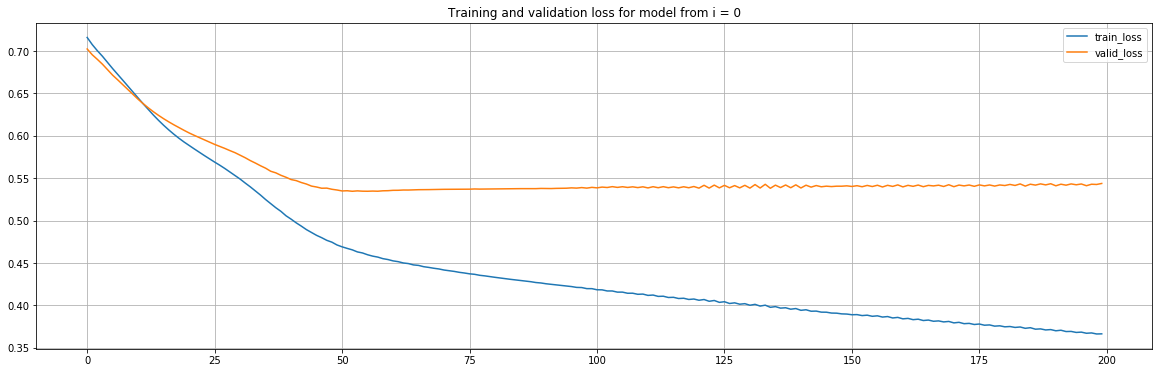

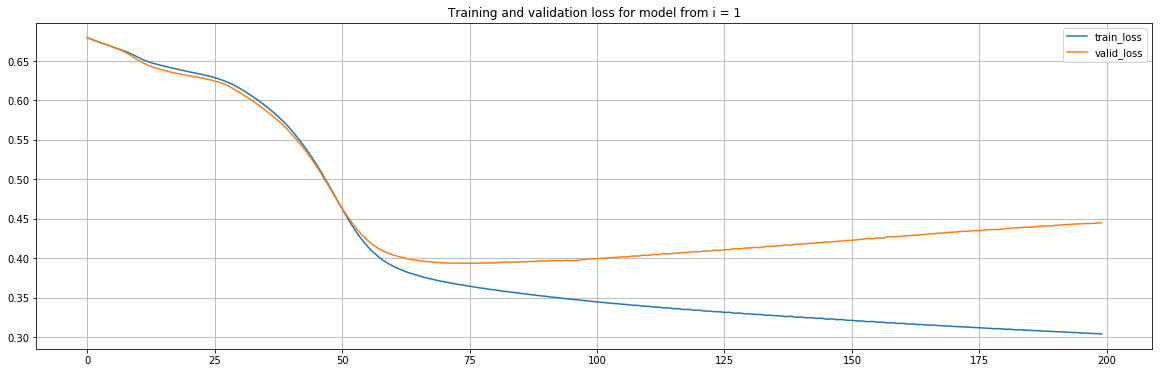

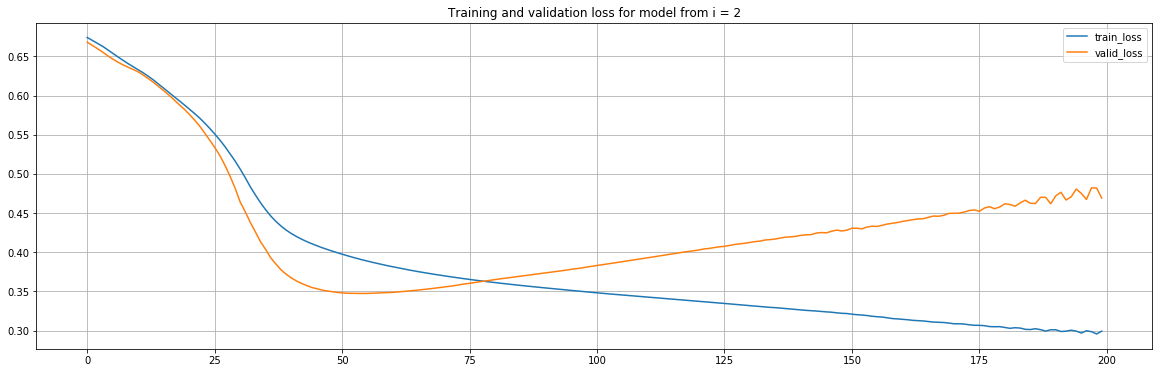

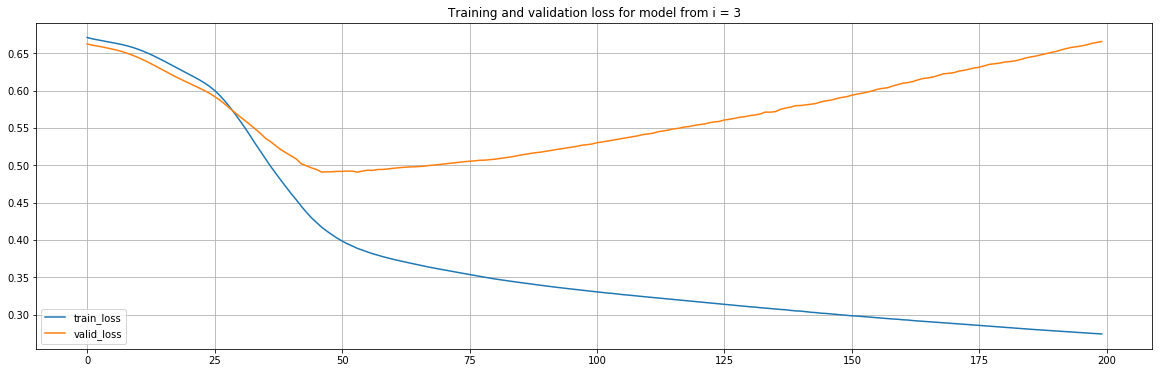

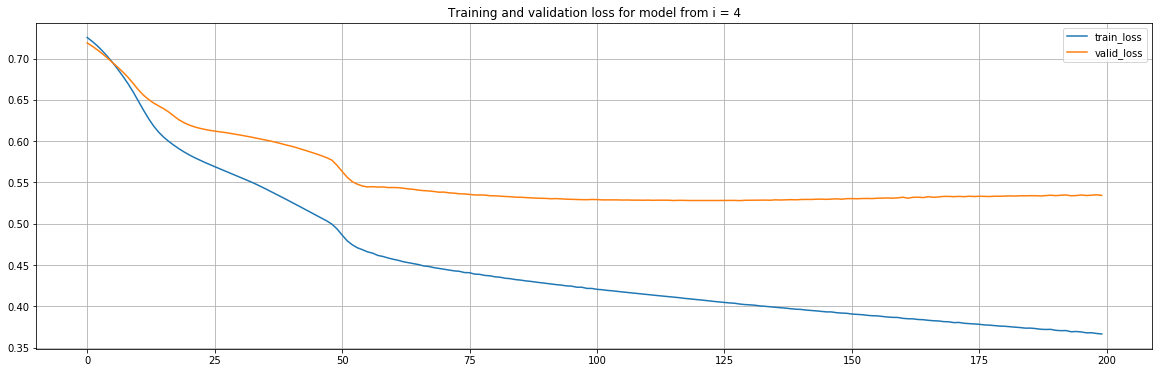

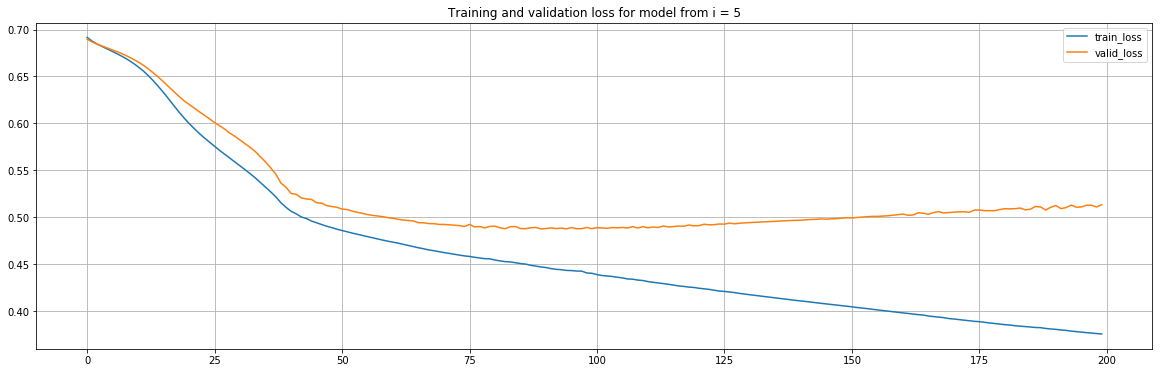

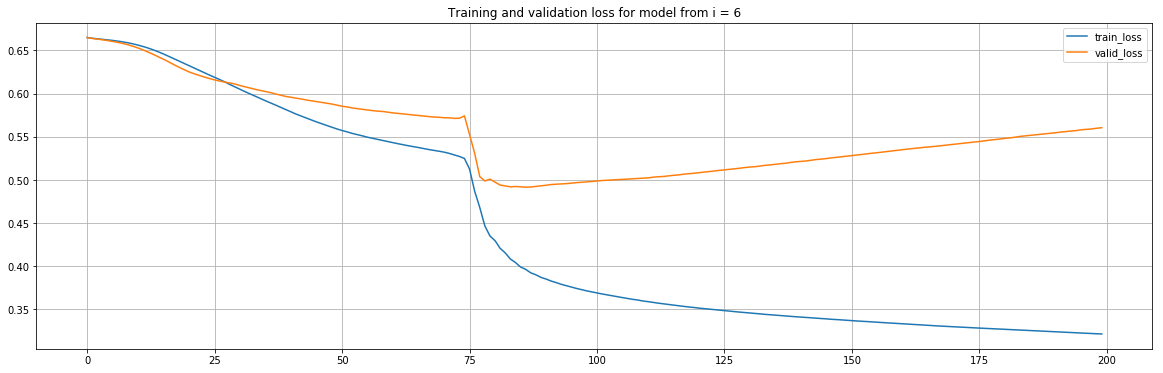

In [1365]:
epochs = range(num_epochs)
for i in range(num_runs):
    model, train_loss, train_acc, valid_loss, valid_acc, train_dl, validation_dl = train_runs[i]
    plt.figure(figsize=(20,6))
    plt.plot(epochs, train_loss, valid_loss)
    plt.grid(True)
    plt.legend(['train_loss', 'valid_loss'])
    plt.title("Training and validation loss for model from i = {}".format(i))

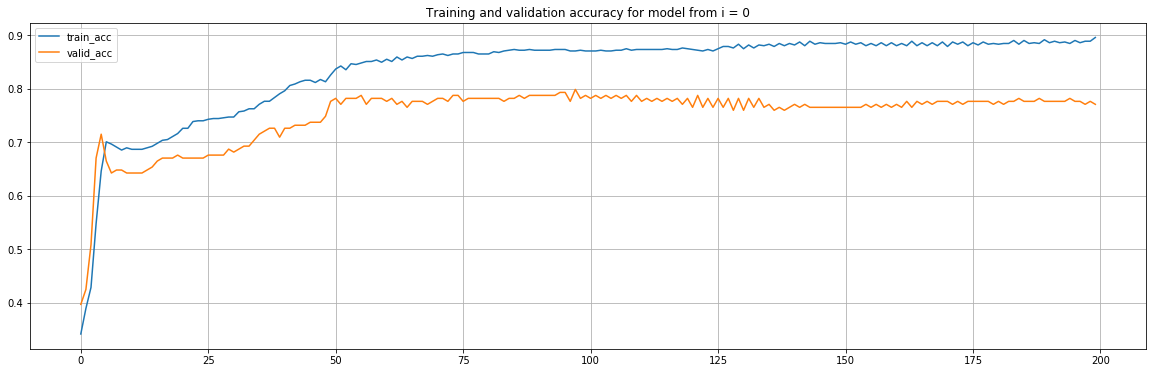

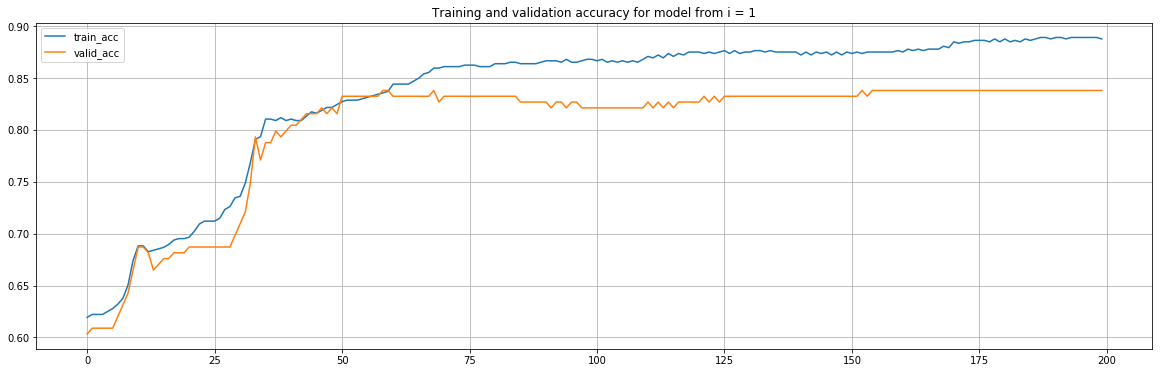

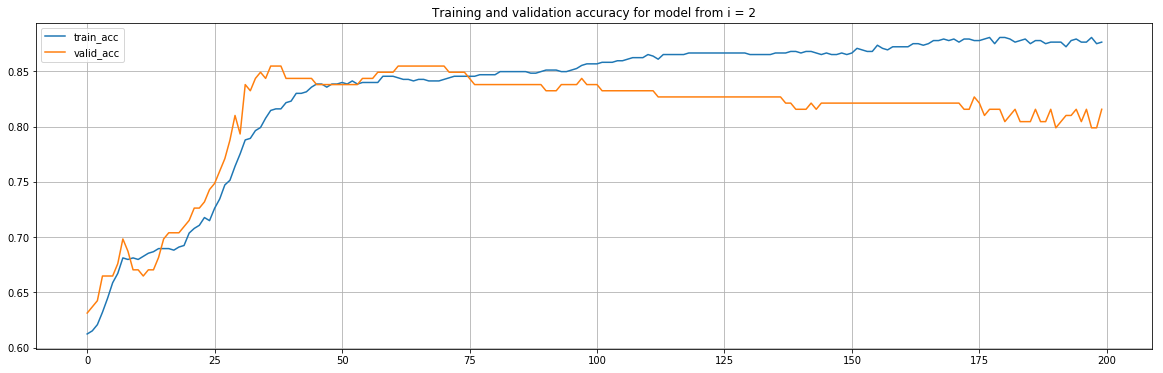

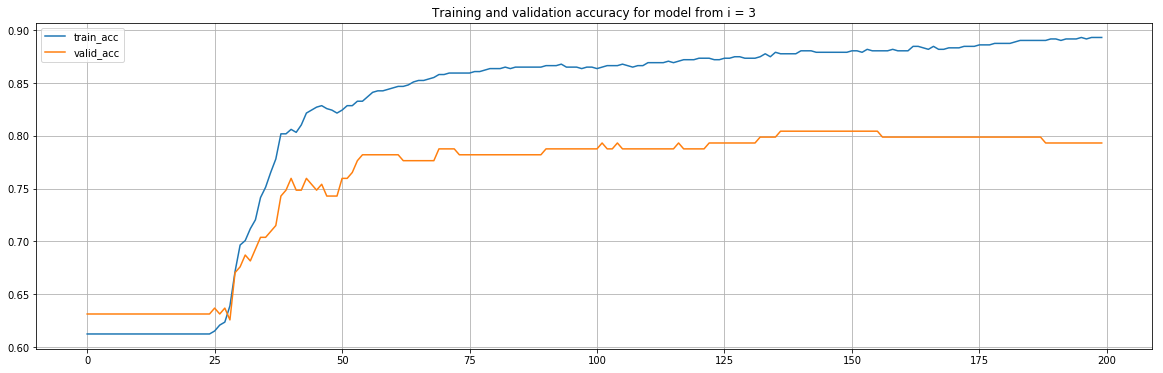

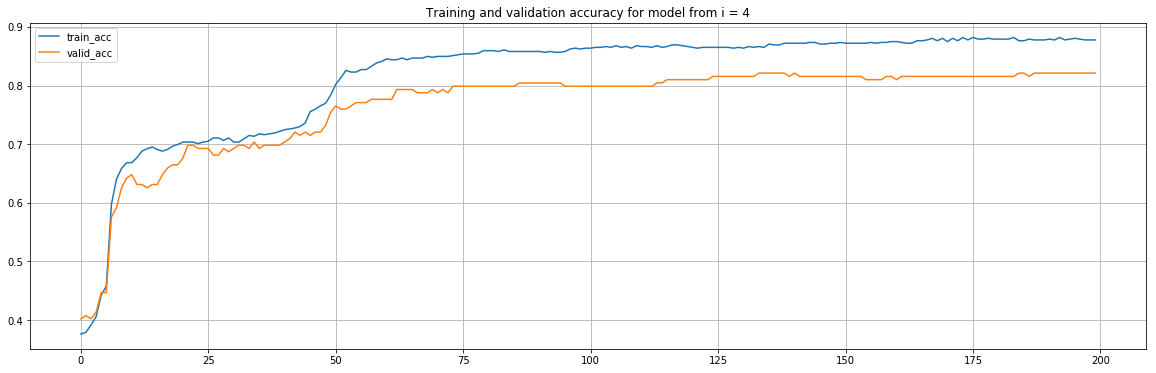

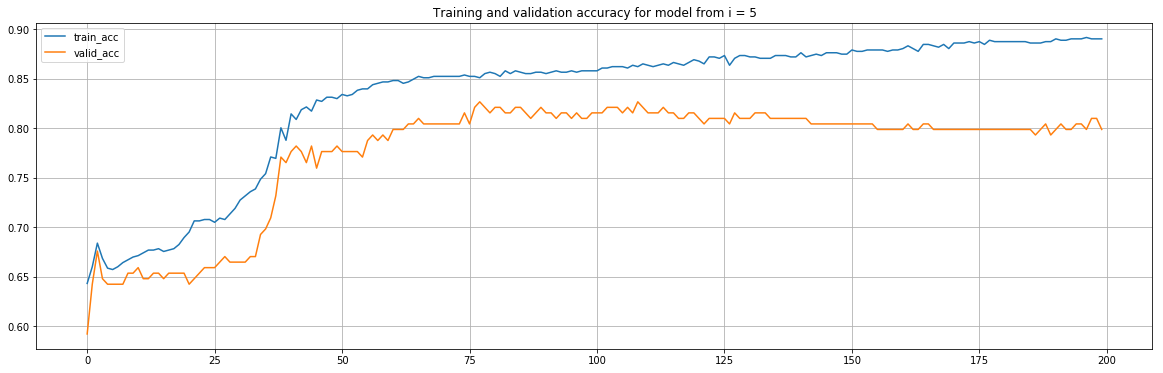

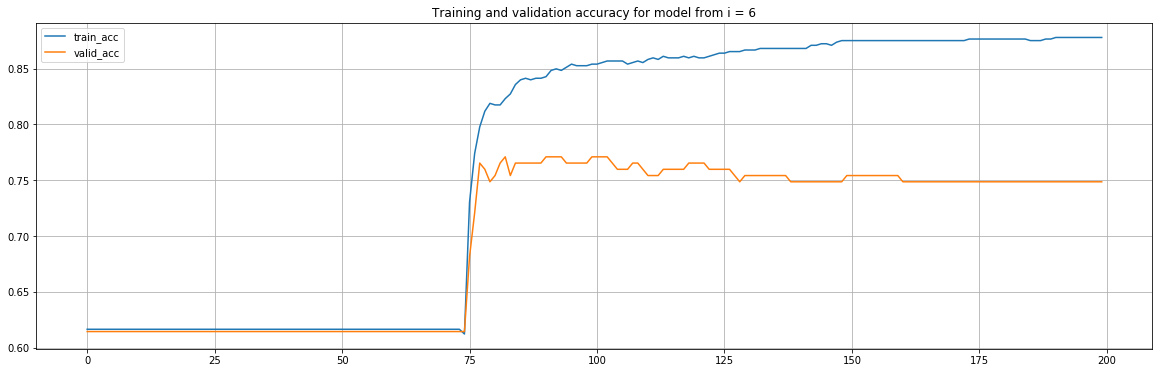

In [1366]:
for i in range(num_runs):
    model, train_loss, train_acc, valid_loss, valid_acc, train_dl, validation_dl = train_runs[i]
    plt.figure(figsize=(20,6))
    plt.plot(epochs, train_acc, valid_acc)
    plt.grid(True)
    plt.legend(['train_acc', 'valid_acc'])
    plt.title("Training and validation accuracy for model from i = {}".format(i))

In [1358]:
model, train_loss, train_acc, valid_loss, valid_acc, train_dl, validation_dl = train_runs[0]

In [1352]:
passenger_ids_pred = []
X_pred = []
Y_pred = []
for idx, row in df_test.iterrows():
    pid, X_row, _ = get_featurized_data(row, False, featureSet)
    X_pred.append(X_row)
    passenger_ids_pred.append(pid)

In [1353]:
f = open('preds.txt', 'w')
f.write("PassengerId,Survived\n")
for i in range(len(X_pred)):
    y_pred = (model(X_pred[i]) > 0.5)
    Y_pred.append(y_pred)
    f.write("{},{}\n".format(passenger_ids_pred[i], y_pred.item()))
f.close()

# Further improvement
In this notebook, we focused mainly on using pytorch for kaggle and
I have used only a simple DNN for this purpose. Considering the size
and nature of this dataset, tree based models might do better. Also
there is scope for more manual feature engineering.